In [143]:
#Importar las librerías por utilizar
import os
import numpy as np
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import math
from skimage import io
from skimage.filters import threshold_otsu
from skimage.transform import resize, probabilistic_hough_line,hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from skimage.color import rgb2gray,rgb2hsv
from skimage.draw import circle_perimeter
from skimage import exposure
from skimage.morphology import disk
from skimage.morphology import (erosion, dilation, opening, closing)
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table
from skimage import data, img_as_float
from skimage import exposure
from scipy import ndimage
import pandas as pd

In [121]:
#Obtener la direccion de las imagenes
path = os.getcwd()


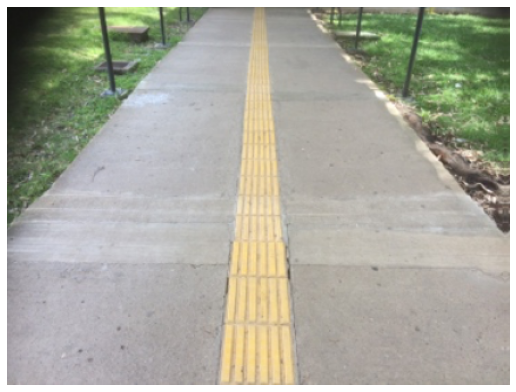

tamaño: (322, 428, 4)


In [122]:
#Imagen original
file_path = os.path.join(path , 'Imagen1.png')
img_org = io.imread(file_path)
shape = img_org.shape

plt.figure(figsize = (9,12))
plt.imshow(img_org)
plt.axis('off')
plt.show()
print('tamaño: ' + str(img_org.shape))

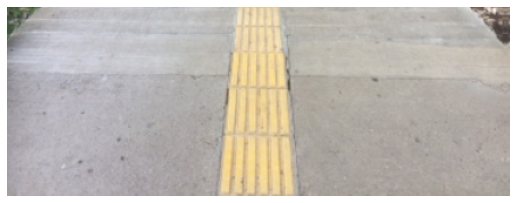

tamaño: (161, 428, 4)


In [123]:
# Escala y Recorta la imagen a 320x240
def edit_image(image):
    y,x = image.shape[:2]
    y_div = y//2
    x_div = x
    cropped = image[y_div:y,0:x_div]
    resized = resize(cropped,(360,320),preserve_range=True).astype(int)
    return resized

resized1 = edit_image(img_org)
plt.figure(figsize = (9,12))
plt.imshow(resized1)
plt.axis('off')
plt.show()
print('tamaño: ' + str(resized1.shape))

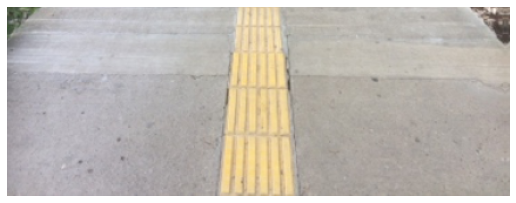

tamaño: (161, 428, 3)


In [128]:
# Convierte la imagen RGBA a RGB
def rgba2rgb( rgba, background=(255,255,255) ):
    row, col, ch = rgba.shape
    if ch == 3:
        return rgba
    assert ch == 4, 'RGBA image has 4 channels.'
    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]
    a = np.asarray( a, dtype='float32' ) / 255.0
    R, G, B = background
    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B
    return np.asarray( rgb, dtype='uint8' )

img_org_RGB =rgba2rgb(resized1)
img_org_HSV =rgb2hsv(img_org_RGB)

plt.figure(figsize = (9,12))
plt.imshow(img_org_RGB)
plt.axis('off')
plt.show()
print('tamaño: ' + str(img_org_RGB.shape))

In [131]:
#PARAMETROS

#numero de colores incluyendo el fondo
N_COLORS = 5

#suma minima del fondo (blanco)
SUM_WHITE = 762 

In [132]:
# Convierte la imagen RGBA a RGB
def rgba2rgb( rgba, background=(255,255,255) ):
    row, col, ch = rgba.shape
    if ch == 3:
        return rgba
    assert ch == 4, 'RGBA image has 4 channels.'
    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]
    a = np.asarray( a, dtype='float32' ) / 255.0
    R, G, B = background
    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B
    return np.asarray( rgb, dtype='uint8' )

img_org_RGB = rgba2rgb( resized1, background=(255,255,255) )

(161, 428, 3)
[0.40392157 0.40980392 0.37803922]
[0.07137203 0.01256361 0.11182933 0.19753086 0.91689498]


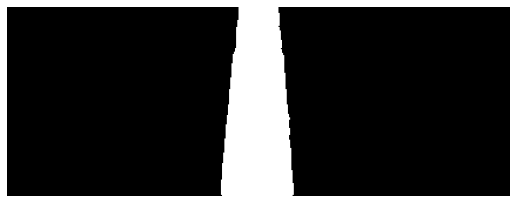

tamaño: (161, 428)


In [151]:
#Quantificacion 4 colores
#https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)

def img_to_5_colors(img):
    # Copia de la imagen por cuantificar
    img_5_colors = img

    # Convert to floats instead of the default 8 bits integer coding. Dividing by
    # 255 is important so that plt.imshow behaves works well on float data (need to
    # be in the range [0-1])
    img_5_colors = np.array(img_5_colors, dtype=np.float64)/255

    # Load Image and transform to a 2D numpy array.
    w, h, d = tuple(img_5_colors.shape)
    print(img_5_colors.shape)
    assert d == 3
    image_array = np.reshape(img_5_colors, (w * h, d))
    image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
    kmeans = KMeans(n_clusters=N_COLORS, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)
    colores = kmeans.cluster_centers_
    print(colores[3])
    coloreshsv = rgb2hsv(colores)[:,0]
    for i in range(N_COLORS):
        if not (0.1 < coloreshsv[i] < 0.19):
            colores[i] = [0, 0, 0]
    print(coloreshsv)


    new_img = recreate_image(colores, labels, w, h)
    new_img = rgb2hsv(new_img)[:,:,2]
    new_img = new_img > threshold_otsu(new_img)
    footprint = disk(5)
    new_img = closing(new_img,footprint)
    return new_img

quant = img_to_5_colors(img_org_RGB)

plt.figure(figsize = (9,12))
plt.imshow(quant,cmap='gray')
plt.axis('off')
plt.show()
print('tamaño: ' + str(quant.shape))

1


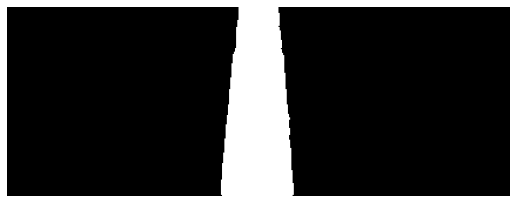

In [156]:
segmented, num_segments = label(quant,return_num = True,connectivity= None)
print(num_segments)
plt.figure(figsize = (9,6))
plt.imshow(segmented, cmap='gray')
plt.axis('off')
plt.show()

props = regionprops(segmented)